In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [2]:
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16

In [3]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
resultsDb = db.ResultsDb(outDir=outDir)



In [4]:
# get the name of all opsim dbs 
import glob

workpath = os.getcwd()
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()



In [5]:
dblist_all[5:6]

['baseline_v1.5_10yrs.db']

In [6]:
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

In [7]:
from lsst.sims.maf.utils import m52snr

class filterPairTGapsMetric(metrics.BaseMetric):
    """
    returns
    N_v * np.exp(-Dkl) for each fields
    
    Parameters:
        colname: 
        fltpair: filter pair, eg ['r', 'i']
        snr_lim: list, signal to noise ratio (fiveSigmaDepth) threshold for fltpair, default [5, 5]
        filename: output a csv table for time gaps of each field
    
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['r', 'i'], tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
                 save_dT=False, filename=None, dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.mag_lim = mag_lim
        self.dataout = dataout
        self.tmin = tmin
        self.tmax = tmax
        self.bins = bins
        self.save_dT = save_dT
        
        self.Nrun = 0   # record the how many time run run()
        if filename!=None:
            if os.path.isfile(filename):
                # rm old file
                os.system("rm {}".format(filename))
                
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
    
    def get_Dkl_i(self, values):
        '''kl divergence for histogram'''
        if values.any():
            values = values + 0.00001  # make each element non-zero
            prob = (values) / values.sum()  
        
            prob_uni = np.ones( len(prob) ) / len(prob)
            return np.sum( prob_uni * np.log(prob_uni / prob) )
        
        else:
            return np.NaN
        
    def get_FoM_i(self, dT_all, tmin=0, tmax=1.5/24, bins=50):
        """return FoM from array of metricValues"""
                
        dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
        Nv = len(dT_tlim)
    
        values, bins_ = np.histogram(dT_tlim, bins=bins);
    
        Dkl = self.get_Dkl_i(values)
    
        FoM_i = Nv * np.exp(-Dkl)
        
        #print(self.Nrun, len(dT_all), Nv, Dkl, FoM_i)
        return Nv, Dkl, FoM_i, dT_tlim
      
    def run(self, dataSlice, slicePoint=None):
        
        # return all possible time gaps for each fields
        
        f0 = self.fltpair[0]
        f1 = self.fltpair[1]
        
        #check input config
        #print(f0, f1, self.tmin, self.tmax, self.mag_lim)
            
        # sort dataSlice
        
        idx0 = ( dataSlice['filter'] == f0 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[0])
        idx1 = ( dataSlice['filter'] == f1 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[1])
        
        timeCol0 = dataSlice['observationStartMJD'][idx0]
        timeCol1 = dataSlice['observationStartMJD'][idx1]

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        #print( 'length of dataSlice', dataSlice.shape )
        # calculate time gaps matrix
        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) ) 
        
        # collect all time gaps
        if f0==f1:
            # get only triangle part
            dt_tri = np.tril(diffmat, -1)
            dT = dt_tri[dt_tri!=0]    # flatten lower triangle 
        else:
            dT = diffmat.flatten()

        Nv, Dkl, FoM_i, dT_tlim = self.get_FoM_i(dT, tmin=self.tmin, tmax=self.tmax, bins=self.bins)
        
        # print(self.Nrun, np.min(dataSlice['fiveSigmaDepth'][idx0]), np.min(dataSlice['fiveSigmaDepth'][idx1]),)
        self.Nrun += 1
        # write results to csv file
        fieldRA = np.mean(dataSlice['fieldRA']) ,
        fieldDec = np.mean(dataSlice['fieldDec']),
        
        if self.save_dT:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                'Dkl': Dkl,
                'FoM_i': FoM_i,
                'dT_lim': dT_tlim
                  }
        else:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                'Dkl': Dkl,
                'FoM_i': FoM_i,
                # 'dT_lim': dT_tlim
                  }
            
        if self.filename!=None:
            self.save_to_file(dic, filename=self.filename)
        
        if self.dataout:
            # return dT
            result = dic
            return result
        else:
        #    f0 = self.fltpair[0]
        #    f1 = self.fltpair[1]
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result) 



In [8]:
def runMetric(dbname, fltpair, ipix_ms=None, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, **kwargs
             ):
    """run filterPairTGapsMetric
    dbname: name of opsim database
    fltpair: filter pair, eg: 'ri'
    ipix_ms: pixIds of footprint
    """
    opsdb = db.OpsimDatabase(dbpath+dbname)
    
    #fltpair = ['r', 'i']
    
    if ipix_ms!=None:
        # use UserPointsSlicer for minisurvey
        ra, dec = pix2radec(nside=nside, ipix=ipix_ms)
        slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    else:
        # use HealpixSlicer 
        slicer = slicers.HealpixSlicer(nside=nside)
    
    # metric, slicer, constraint
    metric = filterPairTGapsMetric( colname=colname, fltpair=fltpair, tmin=tmin, tmax=tmax, bins=bins, mag_lim=mag_lim,
                 filename=filename, dataout=dataout, **kwargs)
    
    sqlconstraint = 'filter in ("{}", "{}")'.format(*fltpair)
    if sqlstr!=None:
        sqlconstraint += ' and {}'.format(sqlstr)
        
    # bundle
    newMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # group bundle
    bundleDict = {'newMetricSky':newMetricSky}
    group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)
    
    # run
    group.runAll()
    #group.plotAll(closefigs = False)
    return newMetricSky



In [9]:
ipix_LMC = [2899, 2900, 2901, 2934, 2935, 2936, 2965, 2966, 2967, 2992, 2993, 2994]
ipix_SMC = [2960, 2961, 2988, 2989, 3012]
ipix_GP = [ 144,  145,  146,  147,  179,  180,  181,  182,  183,  184,  217,
        218,  219,  225,  226,  260,  261,  271,  272,  307,  308,  320,
        321,  358,  374,  413,  431,  432,  471,  472,  493,  534,  535,
        558,  598,  599,  622,  661,  662,  687,  725,  726,  751,  788,
        789,  790,  815,  816,  852,  853,  854,  879,  915,  916,  917,
        944,  979,  980,  981, 1008, 1042, 1043, 1044, 1045, 1073, 1107,
       1108, 1109, 1136, 1170, 1171, 1172, 1201, 1234, 1235, 1236, 1237,
       1265, 1297, 1298, 1299, 1300, 1330, 1361, 1362, 1363, 1364, 1393,
       1425, 1426, 1427, 1428, 1458, 1489, 1490, 1491, 1492, 1522, 1552,
       1553, 1554, 1555, 1587, 1616, 1617, 1618, 1619, 1620, 1650, 1679,
       1680, 1681, 1682, 1683, 1715, 1744, 1745, 1746, 1747, 1779, 1807,
       1808, 1809, 1810, 1811, 1843, 1871, 1872, 1873, 1874, 1875, 1907,
       1934, 1935, 1936, 1937, 1938, 1972, 1998, 1999, 2000, 2001, 2002,
       2003, 2036, 2062, 2063, 2064, 2065, 2066, 2100, 2126, 2127, 2128,
       2129, 2130, 2164, 2189, 2190, 2191, 2192, 2193, 2194, 2229, 2253,
       2254, 2255, 2256, 2257, 2258, 2293, 2316, 2317, 2318, 2319, 2320,
       2321, 2358, 2380, 2381, 2382, 2383, 2384, 2385, 2421, 2422, 2443,
       2444, 2445, 2446, 2447, 2448, 2449, 2486, 2487, 2507, 2508, 2509,
       2510, 2511, 2512, 2513, 2550, 2551, 2570, 2571, 2572, 2573, 2574,
       2575, 2576, 2614, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2673,
       2687, 2688, 2689, 2690, 2691, 2692, 2693, 2728, 2729, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2779, 2780, 2781, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2826, 2827, 2828, 2829, 2830,
       2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2869, 2870,
       2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2908, 2909,
       2910, 2911, 2912, 2913, 2914, 2915, 2916, 2943, 2944, 2945, 2946,
       2947, 2948, 2974, 2975, 2976]


In [10]:
df = pd.read_csv('./data/Fields_nside16.csv')
# LMC, SMC
df['inLMC'] = np.isin(df['pixId'].values, ipix_LMC)
df['inSMC'] = np.isin(df['pixId'].values, ipix_SMC)
df['inGP'] = np.isin(df['pixId'].values, ipix_GP)

df.head()

,pixId,fieldRa,fieldDec,fieldGl,fieldGb,fieldEl,fieldEb,starDensity_r25,TRIstarDensity_r25,inLMC,inSMC,inGP
0,0,45.0,87.075820,124.642960,24.641921,85.217963,64.413844,0,0,False,False,False
1,1,135.0,87.075820,125.753479,28.655621,94.800547,64.412987,0,0,False,False,False
2,2,225.0,87.075820,121.143387,29.592908,95.668530,68.533082,0,0,False,False,False
3,3,315.0,87.075820,120.187742,25.546039,84.354664,68.534126,0,0,False,False,False
4,4,22.5,84.149733,123.982115,21.356778,77.697559,63.791264,0,0,False,False,False


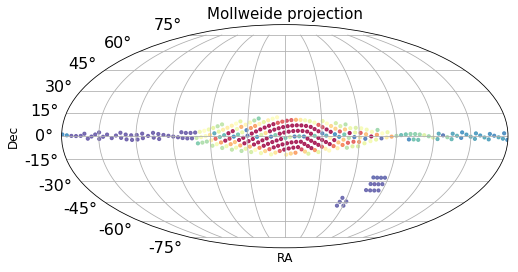

In [15]:
# plot footprint
fig, axs = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 


slicer = ( df['inLMC'] | df['inSMC'] | df['inGP'])
df_ = df[slicer]

#x = df_['fieldRa']
#y = df_['fieldDec']
x = df_['fieldGl']
y = df_['fieldGb']
#c = np.repeat(1.5, len(x))
c = df_['starDensity_r25']
plot_mwd(axs, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)

axs.set_xticklabels([]);

### test run for one opsim

In [11]:
dblist_all[18]

'dcr_nham2_ugri_v1.5_10yrs.db'

In [37]:
ipix_ms = ipix_GP
#dbname = dblist_all[4] # baseline
#dbname = dblist_all[0]

dbname = 'third_obs_pt45v1.5_10yrs.db'
# run one filter pair for baseline
metricSky = runMetric( dbname=dbname, fltpair=['g', 'i'], 
              ipix_ms=ipix_ms, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, save_dT=True)


Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fiveSigmaDepth', 'filter', 'fieldRA', 'observationStartMJD', 'fieldDec']
Found 719288 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [38]:
arr = metricSky.metricValues.data 
        
df = pd.DataFrame.from_records( arr[ arr != None ] )

In [39]:
df

,Dkl,FoM_i,Nrun,Nv,dT_lim,pixId
0,NaN,NaN,1,0,[],622
1,NaN,NaN,2,0,[],661
2,7.833782,0.000792,3,2,"[0.058358355876407586, 0.05794391539529897]",687
3,7.371144,0.000629,4,1,[0.06071237652213313],725
4,NaN,NaN,5,0,[],726
5,8.011193,0.001990,6,6,"[0.05629939065693179, 0.05670790503791068, 0.0...",751
6,8.225301,0.000803,7,3,"[0.014530358188494574, 0.013707963880733587, 0...",788
7,8.275543,0.001273,8,5,"[0.01618225729907863, 0.06111965853051515, 0.0...",789
8,7.371144,0.000629,9,1,[0.06030014438147191],790
9,8.008905,0.000997,10,3,"[0.03950954032188747, 0.04129989320063032, 0.0...",815


In [167]:
dbname

'filterdist_indx1_v1.5_10yrs.db'

In [175]:
data_df = get_cols(dbpath + dbname, cols='fieldRA, fieldDec, night, observationStartMJD, filter, fiveSigmaDepth')


connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/filterdist_indx1_v1.5_10yrs.db 
 SELECT fieldRA, fieldDec, night, observationStartMJD, filter, fiveSigmaDepth FROM SummaryAllProps


In [177]:
data_df['pixId'] = RADec2pix(nside=16, ra=data_df.fieldRA.values, dec=data_df.fieldDec.values )


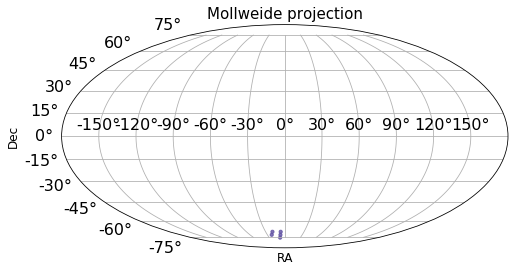

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 

ra, dec = pix2radec(nside=16, ipix=ipix_SMC)
x = ra
y = dec
c = np.repeat(1.5, len(x))

plot_mwd(ax=ax, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)




### run time gaps metrics

In [12]:
def get_Dkl(values):
    '''kl divergence for histogram'''
    if values.any():
        values = values + 0.00001  # make each element non-zero
        prob = (values) / values.sum()  
    
        prob_uni = np.ones( len(prob) ) / len(prob)
        return np.sum( prob_uni * np.log(prob_uni / prob) )
    
    else:
        return np.NaN

def get_FoM_tgaps(df, tmin=0, tmax=1.5/24, bins=50):
    """return FoM from array of metricValues
    Inputs:
     df: pd.DataFrame, cols ['pixId', 'Dkl', 'FoM_i', 'Nv', 'dT_lim']
    """
    
    dT_all = np.concatenate(df.dT_lim.values)
    
    dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
    Nv = len(dT_tlim)

    values, bins_ = np.histogram(dT_tlim, bins=bins);

    Dkl = get_Dkl(values)

    FoM = Nv * np.exp(-Dkl)
    
    return FoM


In [13]:
fltpairs = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy',
           'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy' ]

In [14]:
dblist_all[5:6 ]

['baseline_v1.5_10yrs.db']

In [15]:
%%time 
# run all filter pairs for baseline 

dicFoM = {}
dicFoM['db'] = dblist_all[5:6]

assert(dicFoM['db'] == ['baseline_v1.5_10yrs.db'] )

nside = 16
# select mini survey footprint 
ipix_ms = ipix_GP
msname = 'GP' # minisurvey label used to save files
#sqlstr = "night<4000 and proposalId=1"
sqlstr = "proposalId=1"
#sqlstr = "note not like '%DD%'"

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]

for fltpair in fltpairs: 
    dicFoM[fltpair] = []
    dataRaw[fltpair] = {}
    for dbname in dicFoM['db']: 
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            tmax = 1.5/24 # 1.5 hour in days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
            
        FoM_tgaps = get_FoM_tgaps(df=df, tmin=tmin, tmax=tmax, bins=bins)

        dicFoM[fltpair].append(FoM_tgaps)
        
        dataRaw[fltpair][dbname] = pd.DataFrame.from_records( arr[ arr != None ] )[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        print('>>>', fltpair, dbname, FoM_tgaps)
        
    df_fom = pd.DataFrame(dicFoM)
    df_fom.to_csv('data_v1_5/tgaps_FoM_baseline_v1.5_{}_wfd.csv'.format(msname), index=False)
    # save raw data to pickle
    pd.DataFrame( dataRaw ).to_pickle(outDir+'/dataRaw_v1_5//tgaps_dataRaw_baseline_v1.5_{}_wfd.pkl'.format(msname),)



Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter']
Found 117746 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu baseline_v1.5_10yrs.db 573.4684297527492
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter']
Found 290758 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug baseline_v1.5_10yrs.db 424.70453446396414
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fieldDec', 'fiveSigmaDepth', 'observationStartMJD', 'fieldRA', 'filter']
Found 522979 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.


In [18]:
msname = 'GP'
df_dataRaw = pd.read_pickle( outDir+'/dataRaw_v1_5/tgaps_dataRaw_baseline_v1.5_{}_wfd.pkl'.format(msname) )


In [ ]:
df_dataRaw['rr']['baseline_v1.5_10yrs.db']

In [20]:
# get the median of N visits for each filter pair, 

Nvth = {}
for fltpair in fltpairs: 
    df = df_dataRaw[fltpair]['baseline_v1.5_10yrs.db']
    Nvth[fltpair] = np.median( df.Nv ) 
    

In [21]:
Nvth

{'uu': 1711.0,
 'ug': 44.0,
 'ur': 41.0,
 'ui': 6.0,
 'uz': 0.0,
 'uy': 0.0,
 'gg': 3570.0,
 'gr': 78.0,
 'gi': 11.0,
 'gz': 0.0,
 'gy': 0.0,
 'rr': 19900.0,
 'ri': 110.0,
 'rz': 7.0,
 'ry': 0.0,
 'ii': 20301.0,
 'iz': 139.0,
 'iy': 23.0,
 'zz': 16110.0,
 'zy': 99.0,
 'yy': 17564.0}

In [22]:
Fields = pd.read_csv("./data/Fields_nside16.csv")
starDens = Fields['starDensity_r25'].values
TRIstarDens = Fields['TRIstarDensity_r25'].values

In [ ]:
#### %%time 

# run for all opsims all filter pairs

dicFoMtGaps = {}
dicNfields = {}
dicNstar = {}

dbnames = dblist_all
dicFoMtGaps['db'] = dbnames
dicNfields['db'] = dbnames
dicNstar['db'] = dbnames

nside = 16

# select mini survey footprint 
ipix_ms = ipix_GP
msname = 'GP' # minisurvey label used to save files
#sqlstr = "night<4000 and proposalId=1"
#sqlstr = "proposalId=1"

sqlstr = "note not like '%DD%'"
#sqlstr = None

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
diclist = []
for Nrun in range( len(ipix_ms) ):
    dic = {'Nrun': Nrun, 
                'pixId': ipix_ms[Nrun],
                'Nv': 0,
                'Dkl': 0,
                'FoM_i': 0,
                'dT_lim': []
                  }
    diclist.append(dic)
arr_empty = np.array(diclist)
df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]
#for fltpair in fltpairs[8:]:  
for fltpair in fltpairs:  
    dicFoMtGaps[fltpair] = []
    dicNfields[fltpair] = []
    dicNstar[fltpair] = []
    
    dataRaw[fltpair] = {}
    for dbname in dbnames: 

        print('running ', dbname, fltpair)
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            tmax = 1.5/24 # 1.5 hour in days
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
        
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        if len(df)==0:
            df = df_empty
        # count number of fields/stars above threshold 
        df['starDensity'] = starDens[ df['pixId'].values ] 
        idx = df['Nv'] > Nvth[fltpair]
        Nfields = df['Nv'][idx].shape[0]
        Nstar = np.sum( df['starDensity'][idx] )

        FoM_tgaps = get_FoM_tgaps(df=df, tmin=tmin, tmax=tmax, bins=bins)
                
        dicFoMtGaps[fltpair].append (FoM_tgaps)
        dicNfields[fltpair].append(Nfields)
        dicNstar[fltpair].append(Nstar)
        
        # save the raw data, 
        dataRaw[fltpair][dbname] = df[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        print('>>>', msname, fltpair, dbname, FoM_tgaps, Nfields, Nstar)
    
    df_fom = pd.DataFrame(dicFoMtGaps)
    df_fom.to_csv('data_v1_5/df_tgapsFoM_{}_all.csv'.format(msname), index=False)
    
    df_fom = pd.DataFrame(dicNfields)
    df_fom.to_csv('data_v1_5/df_Nfields_{}_all.csv'.format(msname), index=False)
    
    df_fom = pd.DataFrame(dicNstar)
    df_fom.to_csv('data_v1_5/df_Nstar_{}_all.csv'.format(msname), index=False)
    
    # save raw data to pickle
    pd.DataFrame( dataRaw ).to_pickle(outDir+'/dataRaw_v1_5/tgaps_dataRaw_{}_all.pkl'.format(msname),)




In [295]:
len( dicFoMtGaps['ug'] )

85

In [289]:
dicNfields

{'db': ['agnddf_v1.5_10yrs.db',
  'alt_dust_v1.5_10yrs.db',
  'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db',
  'baseline_2snaps_v1.5_10yrs.db',
  'baseline_v1.5_10yrs.db',
  'bulges_bs_v1.5_10yrs.db',
  'bulges_bulge_wfd_v1.5_10yrs.db',
  'bulges_cadence_bs_v1.5_10yrs.db',
  'bulges_cadence_bulge_wfd_v1.5_10yrs.db',
  'bulges_cadence_i_heavy_v1.5_10yrs.db',
  'bulges_i_heavy_v1.5_10yrs.db',
  'daily_ddf_v1.5_10yrs.db',
  'dcr_nham1_ug_v1.5_10yrs.db',
  'dcr_nham1_ugr_v1.5_10yrs.db',
  'dcr_nham1_ugri_v1.5_10yrs.db',
  'dcr_nham2_ug_v1.5_10yrs.db',
  'dcr_nham2_ugr_v1.5_10yrs.db',
  'dcr_nham2_ugri_v1.5_10yrs.db',
  'descddf_v1.5_10yrs.db',
  'filterdist_indx1_v1.5_10yrs.db',
  'filterdist_indx2_v1.5_10yrs.db',
  'filterdist_indx3_v1.5_10yrs.db',
  'filterdist_indx4_v1.5_10yrs.db',
  'filterdist_indx5_v1.5_10yrs.db',
  'filterdist_indx6_v1.5_10yrs.db',
  'filterdist_indx7_v1.5_10yrs.db',
  'filterdist_indx8_v1.5_10yrs.db',
  'footprint_add_mag_cloudsv1.5_10yrs.db',
  'footprint_big_sky_du

In [283]:
fltpairs

['uu',
 'ug',
 'ur',
 'ui',
 'uz',
 'uy',
 'gg',
 'gr',
 'gi',
 'gz',
 'gy',
 'rr',
 'ri',
 'rz',
 'ry',
 'ii',
 'iz',
 'iy',
 'zz',
 'zy',
 'yy']

In [282]:
arr

array([{'Nrun': 1, 'pixId': 2960, 'Nv': 16, 'Dkl': 9.389035094784543, 'FoM_i': 0.0013381778918751632, 'dT_lim': array([0.03486494, 0.01622914, 0.01663874, 0.03445455, 0.01581876,
       0.01622835, 0.016427  , 0.01637211, 0.01577378, 0.01580907,
       0.01580081, 0.01579388, 0.01629143, 0.01587913, 0.01670415,
       0.01629185])},
       {'Nrun': 2, 'pixId': 2961, 'Nv': 14, 'Dkl': 9.259228921712946, 'FoM_i': 0.0013332021590298263, 'dT_lim': array([0.01629517, 0.01547095, 0.01577593, 0.0162343 , 0.01584717,
       0.04710375, 0.01584275, 0.03891336, 0.01580825, 0.01580039,
       0.01712061, 0.01629639, 0.01578351, 0.01666315])},
       {'Nrun': 3, 'pixId': 2988, 'Nv': 6, 'Dkl': 9.141422083075629, 'FoM_i': 0.0006428091986966666, 'dT_lim': array([0.01629154, 0.01579341, 0.01584644, 0.01577392, 0.01642766,
       0.01580075])},
       {'Nrun': 4, 'pixId': 2989, 'Nv': 9, 'Dkl': 8.84198637092099, 'FoM_i': 0.0013008182446101583, 'dT_lim': array([0.01666357, 0.01580157, 0.0380909 , 0.015842

In [278]:
dicNfields['uu']

[1, 3, 0]

In [122]:
df

""


In [121]:
dblist_all

['agnddf_v1.5_10yrs.db',
 'alt_dust_v1.5_10yrs.db',
 'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db',
 'baseline_2snaps_v1.5_10yrs.db',
 'baseline_v1.5_10yrs.db',
 'bulges_bs_v1.5_10yrs.db',
 'bulges_bulge_wfd_v1.5_10yrs.db',
 'bulges_cadence_bs_v1.5_10yrs.db',
 'bulges_cadence_bulge_wfd_v1.5_10yrs.db',
 'bulges_cadence_i_heavy_v1.5_10yrs.db',
 'bulges_i_heavy_v1.5_10yrs.db',
 'daily_ddf_v1.5_10yrs.db',
 'dcr_nham1_ug_v1.5_10yrs.db',
 'dcr_nham1_ugr_v1.5_10yrs.db',
 'dcr_nham1_ugri_v1.5_10yrs.db',
 'dcr_nham2_ug_v1.5_10yrs.db',
 'dcr_nham2_ugr_v1.5_10yrs.db',
 'dcr_nham2_ugri_v1.5_10yrs.db',
 'descddf_v1.5_10yrs.db',
 'filterdist_indx1_v1.5_10yrs.db',
 'filterdist_indx2_v1.5_10yrs.db',
 'filterdist_indx3_v1.5_10yrs.db',
 'filterdist_indx4_v1.5_10yrs.db',
 'filterdist_indx5_v1.5_10yrs.db',
 'filterdist_indx6_v1.5_10yrs.db',
 'filterdist_indx7_v1.5_10yrs.db',
 'filterdist_indx8_v1.5_10yrs.db',
 'footprint_add_mag_cloudsv1.5_10yrs.db',
 'footprint_big_sky_dustv1.5_10yrs.db',
 'footprint_big_s

In [268]:
dataRaw

{'uu': {'dcr_nham2_ugri_v1.5_10yrs.db':    pixId       Dkl     FoM_i   Nv
  0   2960  8.441504  0.121022  561
  1   2961  7.956633  0.184975  528
  2   2988  8.771589  0.103281  666
  3   2989  8.167952  0.159099  561
  4   3012  7.952372  0.197375  561,
  'descddf_v1.5_10yrs.db':    pixId       Dkl     FoM_i   Nv
  0   2960  8.702763  0.098845  595
  1   2961  8.340162  0.118412  496
  2   2988  8.886447  0.052258  378
  3   2989  8.231738  0.167626  630
  4   3012  7.913657  0.285258  780,
  'filterdist_indx1_v1.5_10yrs.db':    pixId  Dkl  FoM_i  Nv
  0   2960    0      0   0
  1   2961    0      0   0
  2   2988    0      0   0
  3   2989    0      0   0
  4   3012    0      0   0},
 'ug': {'dcr_nham2_ugri_v1.5_10yrs.db':    pixId        Dkl     FoM_i  Nv
  0   2960  10.031224  0.001056  24
  1   2961  10.181962  0.001060  28
  2   2988  10.416150  0.000838  28
  3   2989  10.576983  0.000841  33
  4   3012   9.626473  0.002177  33,
  'descddf_v1.5_10yrs.db':    pixId        Dkl    

In [273]:
msname = 'SMC'
df_dataRaw = pd.read_pickle( outDir+'/tgaps_dataRaw_{}.pkl'.format(msname) )


In [274]:
df_dataRaw

,uu,ug,ur
dcr_nham2_ugri_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 8....,pixId Dkl FoM_i Nv 0 2960 10...,pixId Dkl FoM_i Nv 0 2960 8.2...
descddf_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 8....,pixId Dkl FoM_i Nv 0 2960 9...,pixId Dkl FoM_i Nv 0 2960 8.7...
filterdist_indx1_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 0 0 ...,pixId Dkl FoM_i Nv 0 2960 0 0 ...,pixId Dkl FoM_i Nv 0 2960 0 0 ...


In [275]:
df_dataRaw.loc['filterdist_indx1_v1.5_10yrs.db']['uu']

,pixId,Dkl,FoM_i,Nv
0,2960,0,0,0
1,2961,0,0,0
2,2988,0,0,0
3,2989,0,0,0
4,3012,0,0,0


### utils

In [2]:

def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None, colorbar=True, **kwargs):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
        
    '''
    import numpy as np
    import matplotlib.pyplot as plt

    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax, **kwargs)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

In [1]:
#  get columns from databases
def get_cols(dbfile, cols='night', lim=None):
    """
    cols = 'night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note'
    connect to database
    Returns: a pandas DataFrame
    
    Examples:
    
    cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note, '

    df = get_cols(dbfile=dbpath + db, cols=cols, lim='night<300')
   
    """
    import sqlite3
    import pandas as pd
    connection = sqlite3.connect(dbfile)
    cursor = connection.cursor()
    
    if lim!=None:
        sqlstr = "SELECT {} FROM SummaryAllProps where {}".format(cols, lim)
    else:
        sqlstr = "SELECT {} FROM SummaryAllProps".format(cols)

    print('connect to ', dbfile, '\n', sqlstr)
    cursor.execute(sqlstr)
    data = cursor.fetchall()
    
    # convert data to dataframe
    data_df = pd.DataFrame(data, columns=cols.split(', '))
    
    # close connection
    connection.close()
    
    return data_df
